In [1]:
import pandas as pd
import os
import random
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import stft
from scipy.io import wavfile
from scipy.ndimage import zoom
import shutil
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.signal import resample
from audiomentations import AddGaussianNoise, PitchShift, TimeMask, SpecFrequencyMask, Normalize, AddGaussianSNR

import faiss
from faiss import write_index, read_index

In [2]:
pickles = {}
for file in os.listdir("data/Pickle Folder"):
    f = os.path.splitext(file)[0]
    pickles[f] = pd.read_pickle("data/Pickle Folder/" + file)

FB_18Dec2019_specgenCL0005_ShortPatience


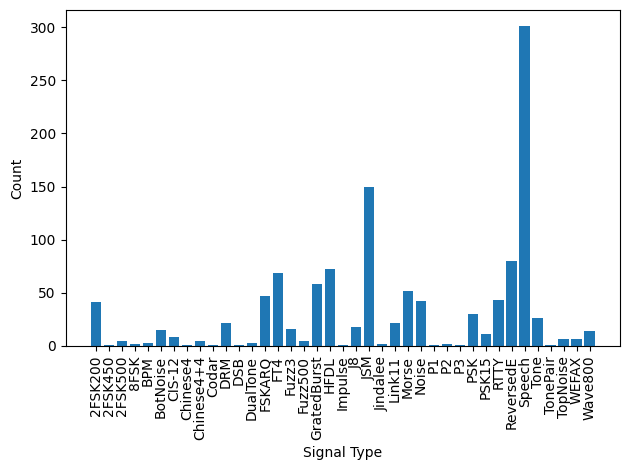

.ipynb_checkpoints


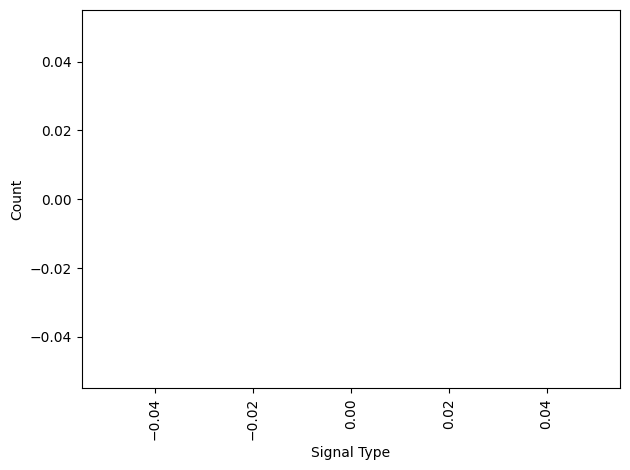

FB_13Jan2021_8am_specgenCL0005_ShortPatience


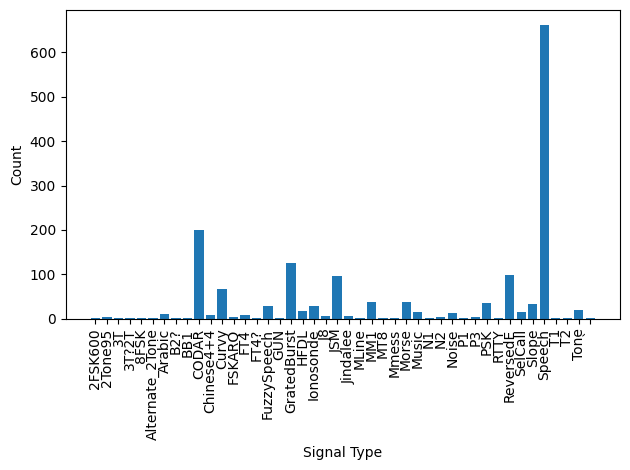

FB_13Jan2021_7am_specgenCL0005_ShortPatience


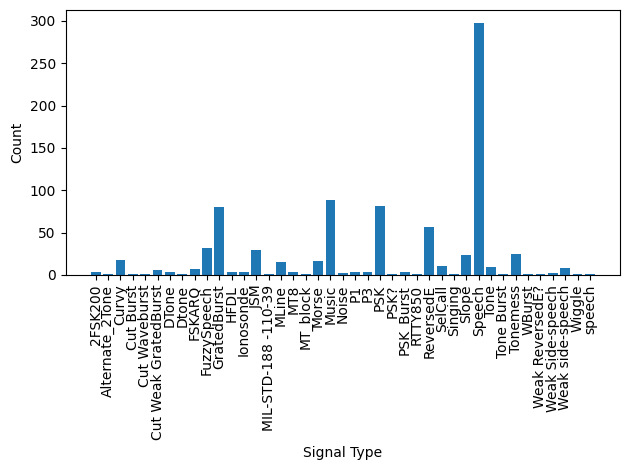

In [9]:
# check data distribution in the 3 different folders
dir = "data/labelled"
for folder in os.listdir(dir):
    counts_by_type = {}
    print(folder)
    folder_path = os.path.join(dir, folder)
    for file in os.listdir(folder_path):
        file_name = os.path.splitext(file)[0]
        classes = pickles[folder]["GTLabelnamesAll"][file_name]
        for c in classes:
            if c not in counts_by_type:
                counts_by_type[c] = 0
            counts_by_type[c] += 1
            
    counts_by_type = dict(sorted(counts_by_type.items()))
    keys = list(counts_by_type.keys())
    values = list(counts_by_type.values())
    plt.bar(keys, values)
    plt.xlabel('Signal Type')
    plt.ylabel('Count')
    plt.xticks(rotation=90)  # Rotate x-axis labels by 45 degrees
    plt.tight_layout()  # Adjust the spacing between labels
    plt.savefig(folder+".png")
    plt.show()

Train
{'2FSK200': 3, '2FSK600': 2, '2Tone95': 5, '3T': 1, '3T?2T': 1, '8FSK': 1, 'Alternate_2Tone': 3, 'Arabic': 10, 'B2?': 1, 'BB1': 1, 'CODAR': 200, 'Chinese4+4': 8, 'Curvy': 86, 'Cut Burst': 1, 'Cut Waveburst': 1, 'Cut Weak GratedBurst': 6, 'DTone': 3, 'Dtone': 1, 'FSKARQ': 12, 'FT4': 8, 'FT4?': 1, 'FuzzySpeech': 61, 'GUN': 1, 'GratedBurst': 206, 'HFDL': 21, 'Ionosonde': 34, 'J8': 6, 'JSM': 126, 'Jindalee': 7, 'MIL-STD-188 -110-39': 1, 'MLine': 16, 'MM1': 39, 'MT8': 5, 'MT_block': 1, 'Mmess': 1, 'Morse': 55, 'Music': 105, 'N1': 1, 'N2': 5, 'Noise': 16, 'P1': 5, 'P3': 8, 'PSK': 117, 'PSK?': 1, 'PSK_Burst': 3, 'RTTY': 3, 'RTTY850': 1, 'ReversedE': 156, 'SelCall': 26, 'Singing': 1, 'Slope': 56, 'Speech': 960, 'T1': 3, 'T2': 1, 'Tone': 29, 'Tone Burst': 1, 'Tonemess': 25, 'WBurst': 1, 'Weak ReversedE?': 1, 'Weak Side-speech': 2, 'Weak side-speech': 8, 'Wiggle': 1, '`': 1, 'speech': 1}


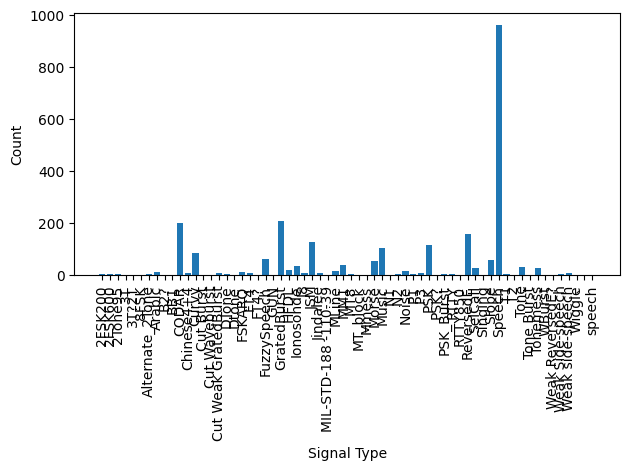

39
Test
{'2FSK200': 41, '2FSK450': 1, '2FSK500': 5, '8FSK': 2, 'BPM': 3, 'BotNoise': 15, 'CIS-12': 8, 'Chinese4': 1, 'Chinese4+4': 5, 'Codar': 1, 'DRM': 22, 'DSB': 1, 'DualTone': 3, 'FSKARQ': 47, 'FT4': 69, 'Fuzz3': 16, 'Fuzz500': 5, 'GratedBurst': 58, 'HFDL': 72, 'Impulse': 1, 'J8': 18, 'JSM': 150, 'Jindalee': 2, 'Link11': 22, 'Morse': 52, 'Noise': 42, 'P1': 1, 'P2': 2, 'P3': 1, 'PSK': 30, 'PSK15': 11, 'RTTY': 43, 'ReversedE': 80, 'Speech': 301, 'Tone': 26, 'TonePair': 1, 'TopNoise': 7, 'WEFAX': 7, 'Wave800': 14}


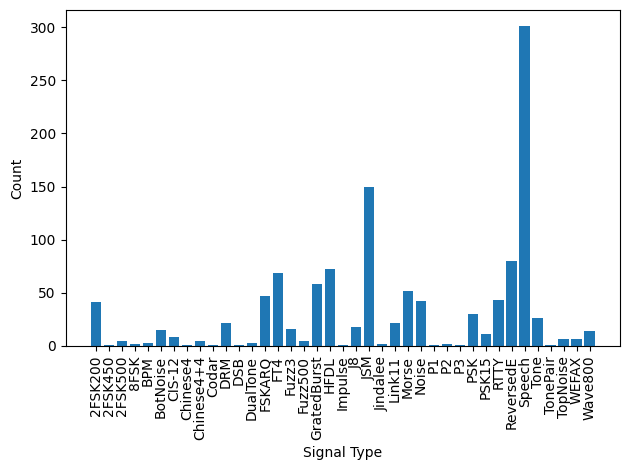

In [12]:
# check data distribution in the train and test sets
dir = "data/labelled"
counts_by_type = {}
counts_by_type2 = {}
for folder in os.listdir(dir):
    if folder.startswith("FB_13"):
        folder_path = os.path.join(dir, folder)
        for file in os.listdir(folder_path):
            file_name = os.path.splitext(file)[0]
            classes = pickles[folder]["GTLabelnamesAll"][file_name]
            for c in classes:
                if c not in counts_by_type:
                    counts_by_type[c] = 0
                counts_by_type[c] += 1
    else:
        folder_path = os.path.join(dir, folder)
        for file in os.listdir(folder_path):
            file_name = os.path.splitext(file)[0]
            classes = pickles[folder]["GTLabelnamesAll"][file_name]
            for c in classes:
                if c not in counts_by_type2:
                    counts_by_type2[c] = 0
                counts_by_type2[c] += 1

counts_by_type = dict(sorted(counts_by_type.items()))
# counts_by_type = {key: value for key, value in counts_by_type.items() if value >= 10}
print("Train")
print(counts_by_type)
keys = list(counts_by_type.keys())
values = list(counts_by_type.values())
plt.bar(keys, values)
plt.xlabel('Signal Type')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()  # Adjust the spacing between labels
plt.show()

# counts_by_type2 = {key: value for key, value in counts_by_type2.items() if value >= 10}
counts_by_type2 = dict(sorted(counts_by_type2.items()))
print(len(counts_by_type2))
print("Test")
print(counts_by_type2)
keys = list(counts_by_type2.keys())
values = list(counts_by_type2.values())
plt.bar(keys, values)
plt.xlabel('Signal Type')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()  # Adjust the spacing between labels
plt.show()